In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from glob import glob
%config InlineBackend.figure_format = 'svg'

def load_notmnist(path='./notMNIST_small',letters='ABCDEFGHIJ',
                  img_shape=(28,28),test_size=0.25,one_hot=False):
    
    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        print("Downloading data...")
        assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0
    
    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters: 
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)
        
    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))
    
    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')
    
    #split into train/test
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels)
    
    print("Done")
    return X_train, y_train, X_test, y_test

Training Accuracy: 95.39%
Test Accuracy: 88.16%


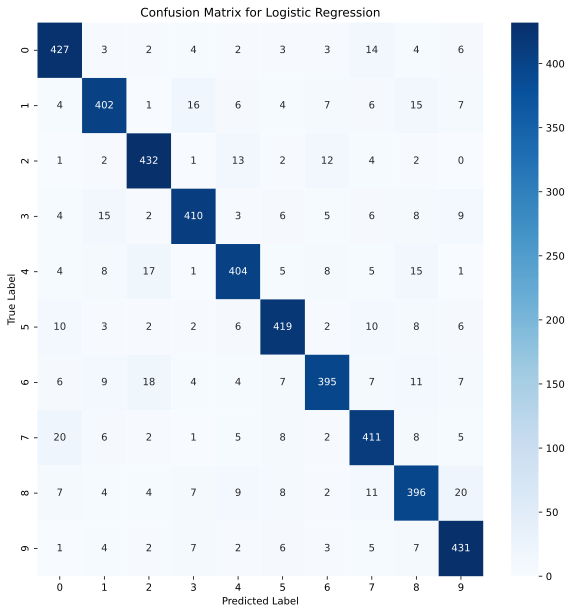

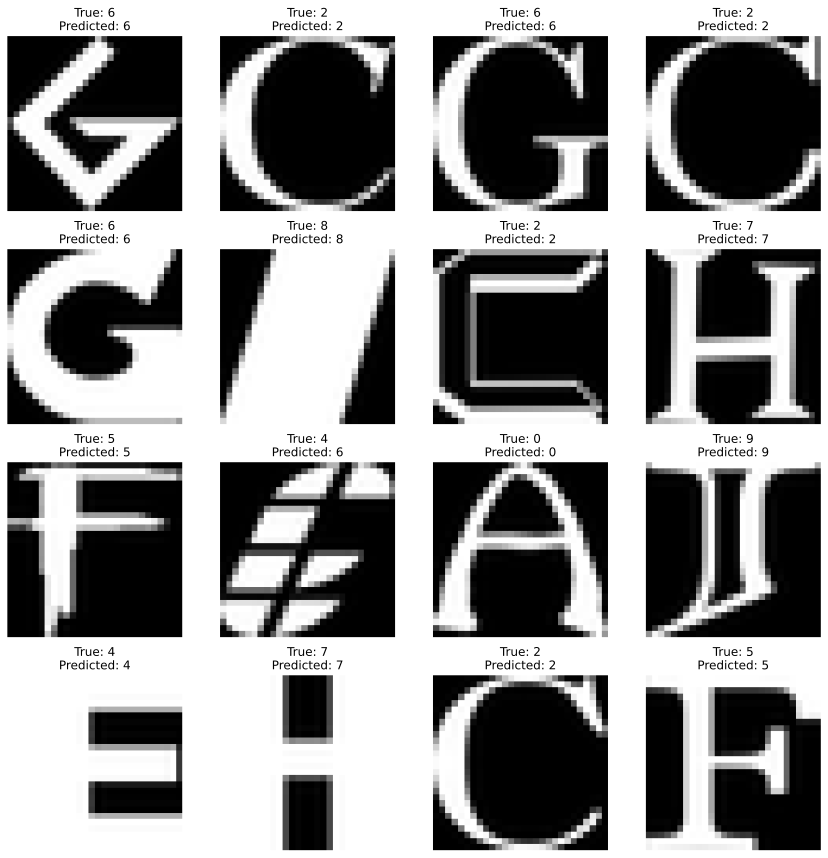

CPU times: user 1min 17s, sys: 2.7 s, total: 1min 20s
Wall time: 11.2 s


In [49]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

log_reg = LogisticRegression(C=0.1, max_iter=1000, solver='lbfgs', random_state=42)
log_reg.fit(X_train_flat, y_train)

y_train_pred = log_reg.predict(X_train_flat)
y_test_pred = log_reg.predict(X_test_flat)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(16):
    idx = np.random.randint(0, X_test.shape[0])
    axes[i].imshow(X_test[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'True: {y_test[idx]}\nPredicted: {y_test_pred[idx]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


Training Accuracy: 99.96%
Test Accuracy: 88.04%


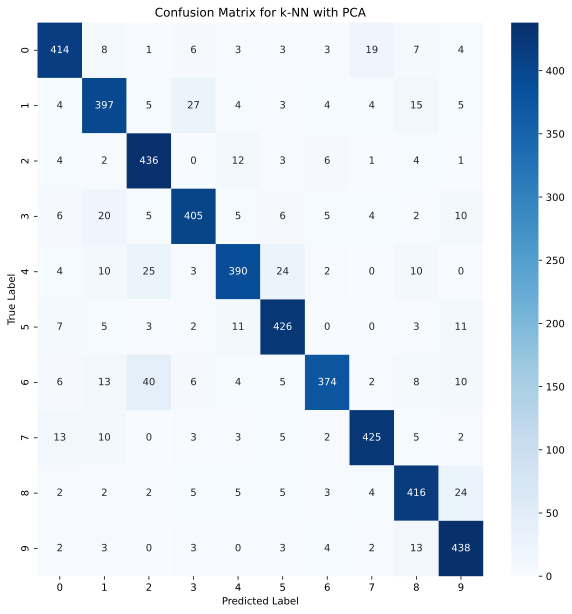

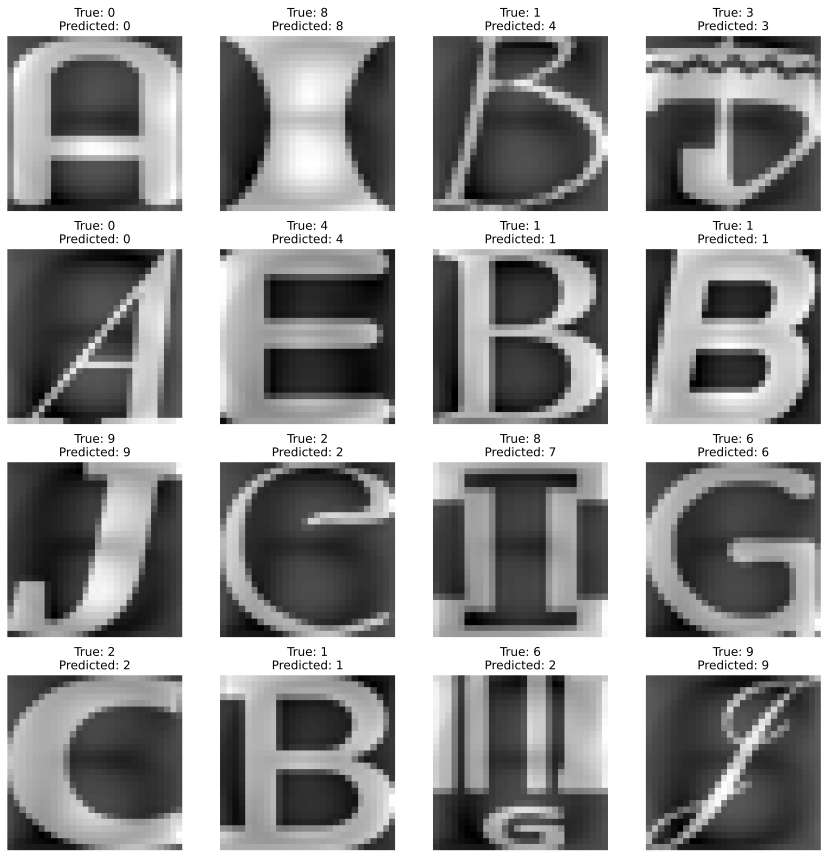

CPU times: user 14 s, sys: 1.24 s, total: 15.3 s
Wall time: 2.53 s


In [42]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train.reshape((X_train.shape[0], -1)))
X_test_flat = scaler.transform(X_test.reshape((X_test.shape[0], -1)))

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

knn = KNeighborsClassifier(n_neighbors=7, weights='distance')

knn.fit(X_train_pca, y_train)

y_train_pred = knn.predict(X_train_pca)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2%}")

y_test_pred = knn.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2%}")

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for k-NN with PCA')
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(16):
    idx = np.random.randint(0, X_test_pca.shape[0])
    axes[i].imshow(X_test_flat[idx].reshape(28, 28), cmap='gray')  # Reshape back to 28x28 after flattening
    axes[i].set_title(f'True: {y_test[idx]}\nPredicted: {y_test_pred[idx]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


Training Accuracy: 80.87%
Test Accuracy: 80.18%


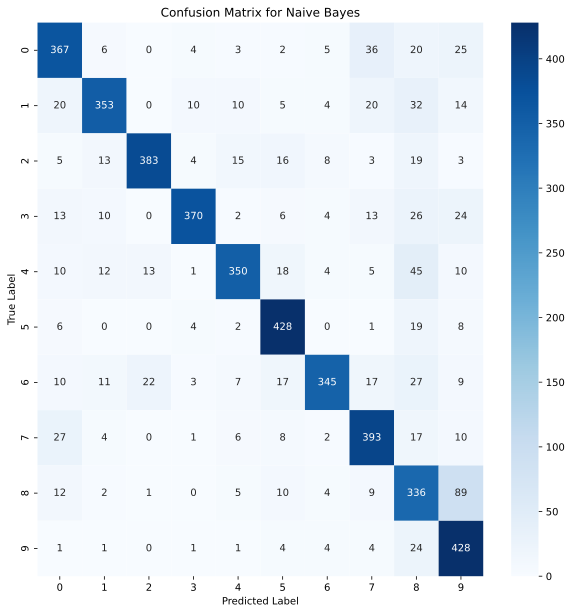

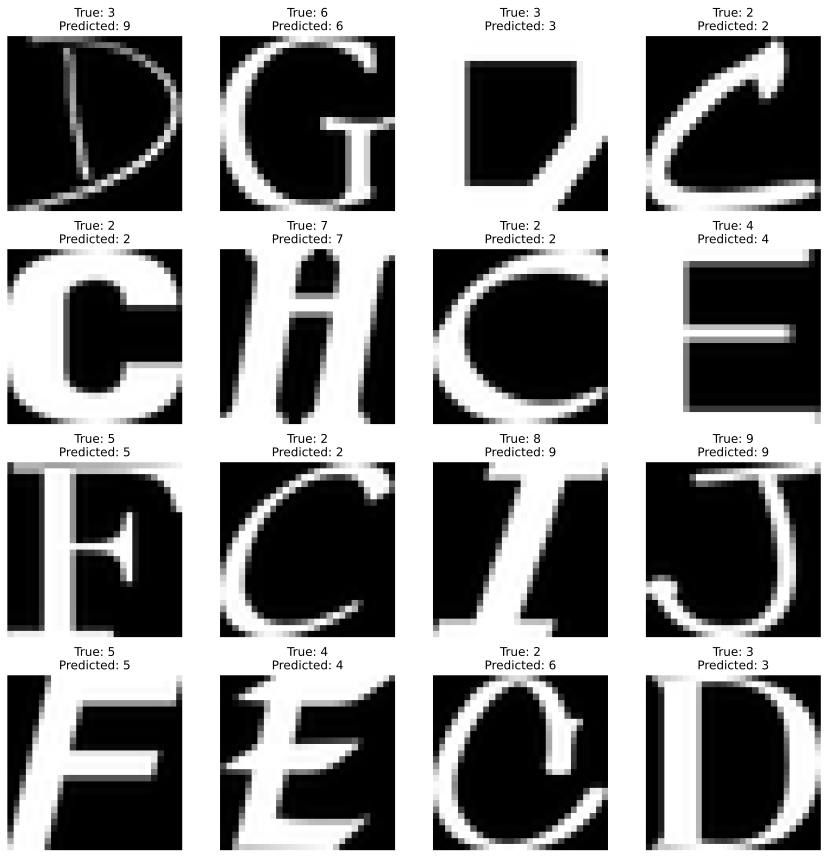

CPU times: user 2.2 s, sys: 305 ms, total: 2.51 s
Wall time: 1.28 s


In [50]:
%%time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

gnb = GaussianNB()

gnb.fit(X_train_flat, y_train)

y_train_pred = gnb.predict(X_train_flat)
y_test_pred = gnb.predict(X_test_flat)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(16):
    idx = np.random.randint(0, X_test_flat.shape[0])
    axes[i].imshow(X_test_flat[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'True: {y_test[idx]}\nPredicted: {y_test_pred[idx]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


Training Accuracy: 99.96%
Test Accuracy: 81.82%


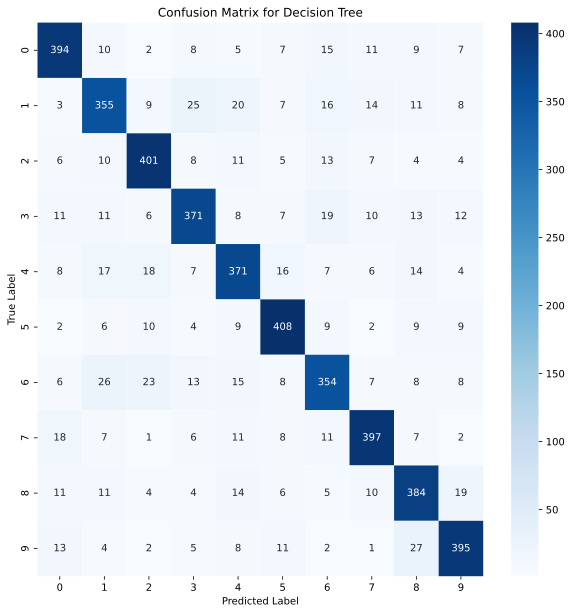

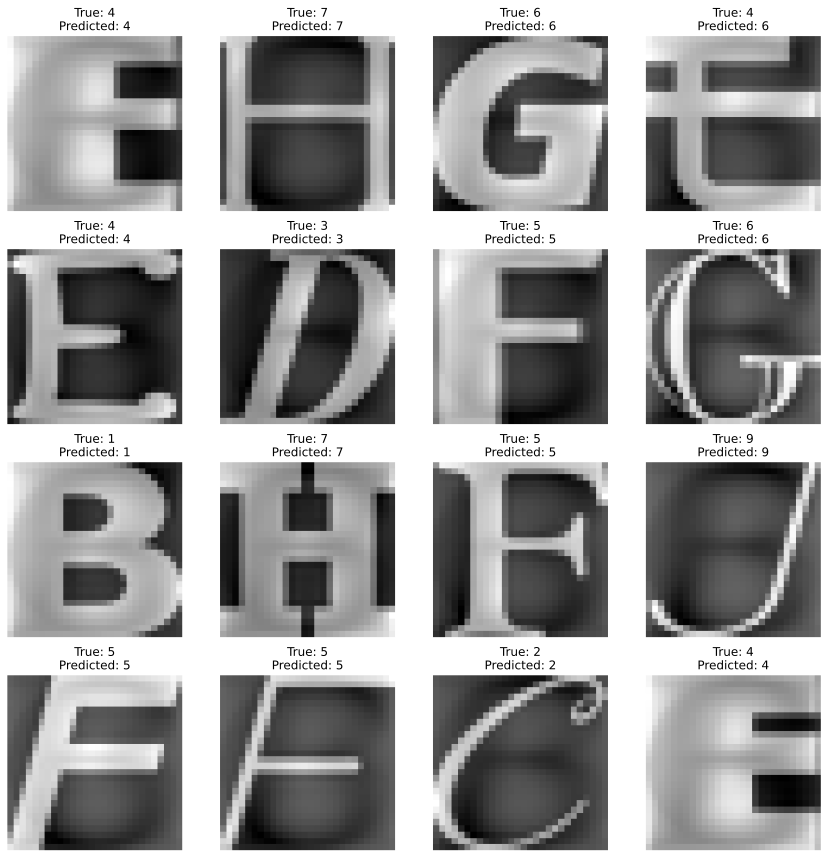

CPU times: user 4.61 s, sys: 70.1 ms, total: 4.68 s
Wall time: 3.8 s


In [44]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train_flat, y_train)

y_train_pred = dt.predict(X_train_flat)
y_test_pred = dt.predict(X_test_flat)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(16):
    idx = np.random.randint(0, X_test_flat.shape[0])
    axes[i].imshow(X_test_flat[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'True: {y_test[idx]}\nPredicted: {y_test_pred[idx]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


Training Accuracy: 99.96%
Test Accuracy: 90.88%


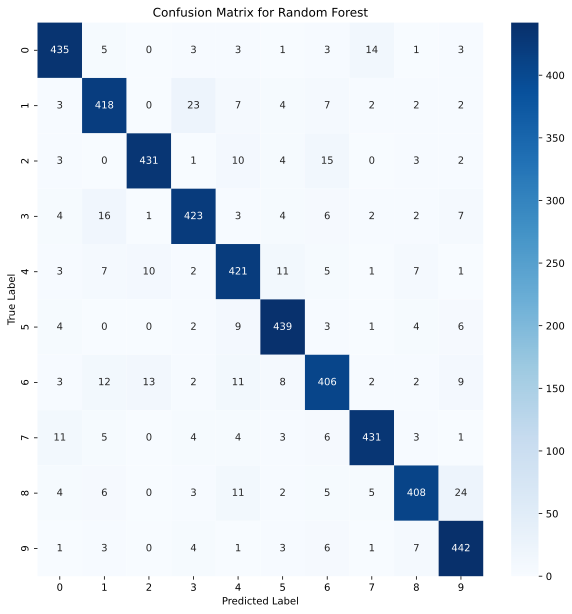

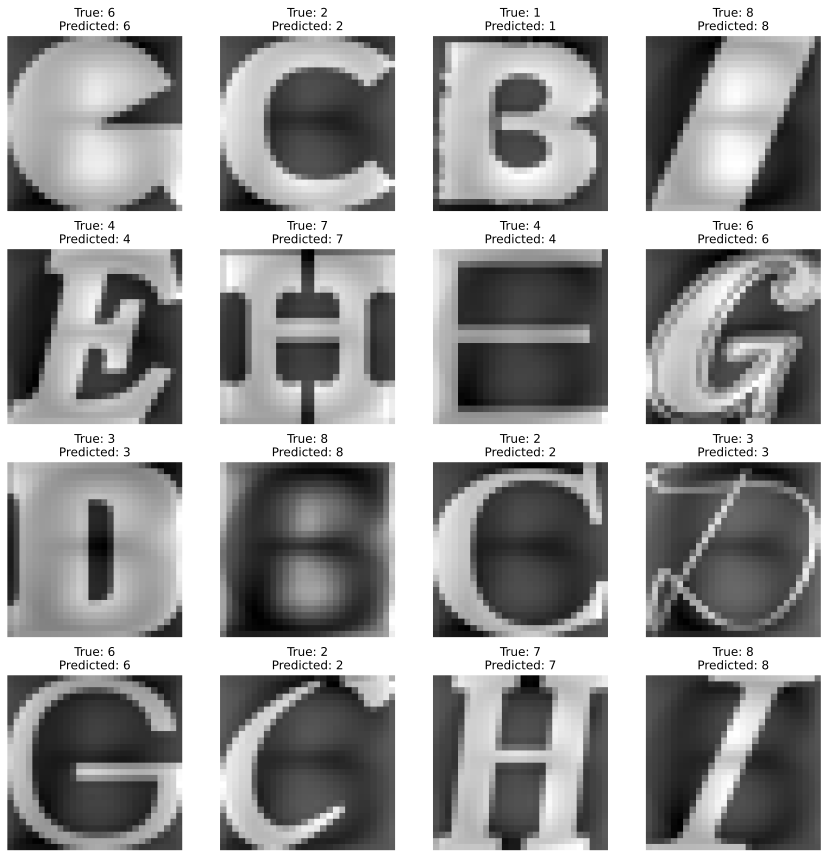

CPU times: user 9.64 s, sys: 66.6 ms, total: 9.71 s
Wall time: 8.85 s


In [45]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train_flat, y_train)

y_train_pred = rf.predict(X_train_flat)
y_test_pred = rf.predict(X_test_flat)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")


conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest')
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(16):
    idx = np.random.randint(0, X_test_flat.shape[0])
    axes[i].imshow(X_test_flat[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'True: {y_test[idx]}\nPredicted: {y_test_pred[idx]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


Training Accuracy: 97.09%
Test Accuracy: 90.58%


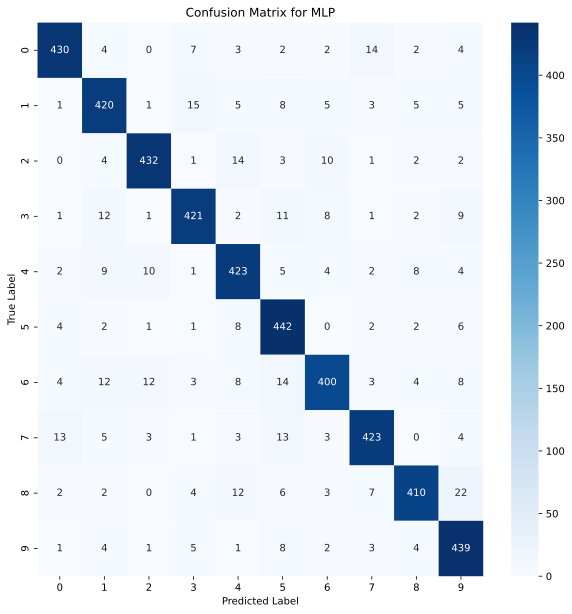

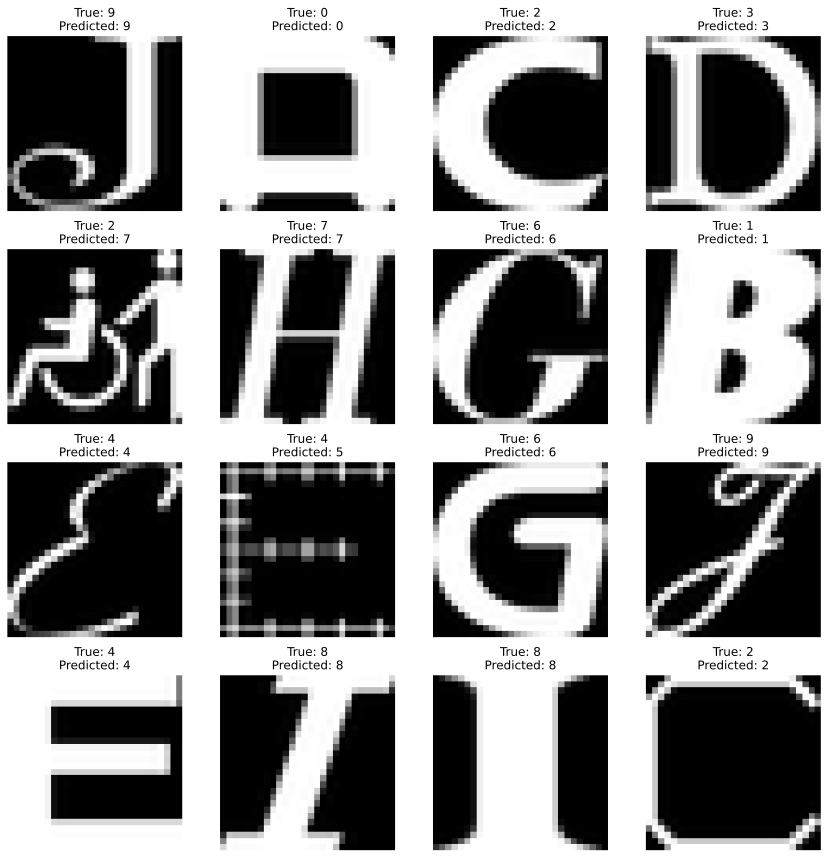

CPU times: user 32.2 s, sys: 2.27 s, total: 34.5 s
Wall time: 5.12 s


In [51]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 128), 
    activation='relu',  
    solver='adam', 
    alpha=0.0001,
    max_iter=200,
    early_stopping=True, 
    validation_fraction=0.1,  
    n_iter_no_change=10, 
    random_state=42
)

mlp.fit(X_train_flat, y_train)

y_train_pred = mlp.predict(X_train_flat)
y_test_pred = mlp.predict(X_test_flat)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP')
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(16):
    idx = np.random.randint(0, X_test_flat.shape[0])
    axes[i].imshow(X_test_flat[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'True: {y_test[idx]}\nPredicted: {y_test_pred[idx]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [34]:
pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/85/15/cf99a373812d37f8ae99752a34a9f5f690d820ceb5b302e922705bc18944/tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for tensorflow-macos==2.15.0 from https://files.pythonhosted.org/packages/eb/9f/0759e2fea4a3c48f070b64811c2c57036b46353ba87263afc810b8f4188a/tensorflow_macos-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 513.7 kB/s eta 0:00:00 0:00:01
  Obtaining depen

  Obtaining dependency information for tensorboard-data-server<0.8.0,>=0.7.0 from https://files.pythonhosted.org/packages/7a/13/e503968fefabd4c6b2650af21e110aa8466fe21432cd7c43a84577a89438/tensorboard_data_server-0.7.2-py3-none-any.whl.metadata
  Obtaining dependency information for cachetools<6.0,>=2.0.0 from https://files.pythonhosted.org/packages/a2/91/2d843adb9fbd911e0da45fbf6f18ca89d07a087c3daa23e955584f90ebf4/cachetools-5.3.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 MB 4.2 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 1.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 5.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 2.4 MB/s eta 0:00:0000:0100:01
   ━━━━━

Epoch 1/10
395/395 [==============================] - 3s 7ms/step - loss: 0.8631 - accuracy: 0.7245 - val_loss: 0.4027 - val_accuracy: 0.8833
Epoch 2/10
395/395 [==============================] - 3s 7ms/step - loss: 0.4451 - accuracy: 0.8631 - val_loss: 0.3129 - val_accuracy: 0.9068
Epoch 3/10
395/395 [==============================] - 3s 7ms/step - loss: 0.3605 - accuracy: 0.8914 - val_loss: 0.2797 - val_accuracy: 0.9125
Epoch 4/10
395/395 [==============================] - 3s 7ms/step - loss: 0.3274 - accuracy: 0.9010 - val_loss: 0.2690 - val_accuracy: 0.9189
Epoch 5/10
395/395 [==============================] - 3s 7ms/step - loss: 0.2968 - accuracy: 0.9073 - val_loss: 0.2667 - val_accuracy: 0.9174
Epoch 6/10
395/395 [==============================] - 3s 7ms/step - loss: 0.2774 - accuracy: 0.9164 - val_loss: 0.2620 - val_accuracy: 0.9267
Epoch 7/10
395/395 [==============================] - 3s 7ms/step - loss: 0.2579 - accuracy: 0.9174 - val_loss: 0.2461 - val_accuracy: 0.9174
Epoch 

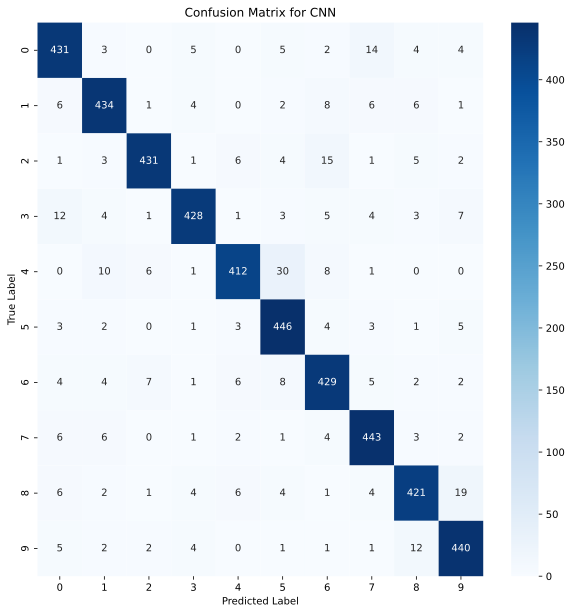

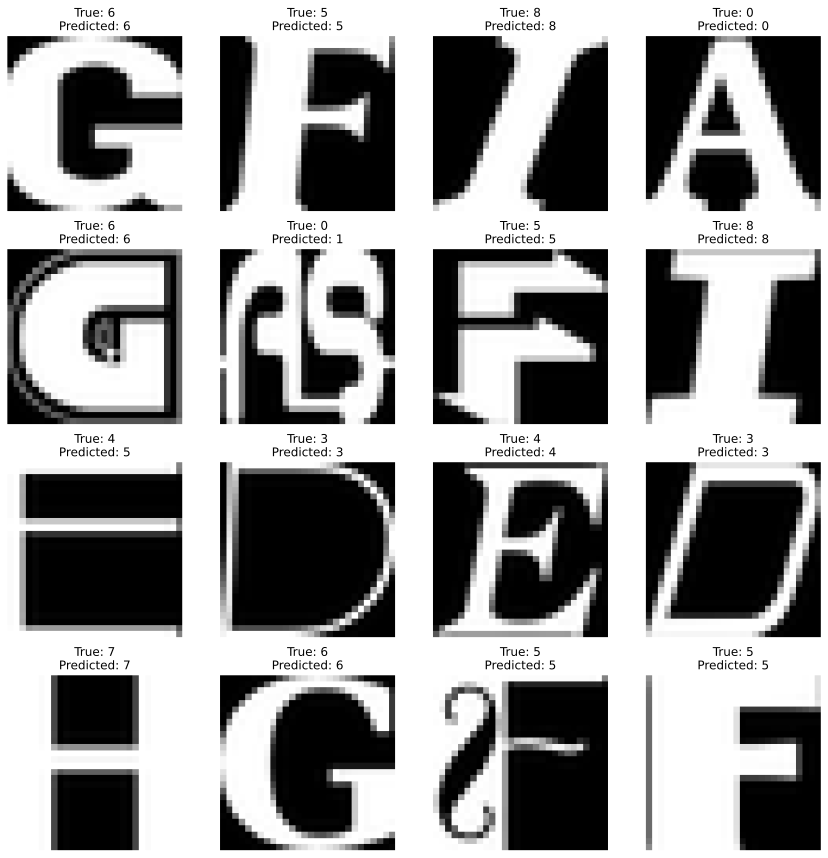

CPU times: user 1min 36s, sys: 16.9 s, total: 1min 53s
Wall time: 30.2 s


In [47]:
%%time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

X_train_cnn = X_train.reshape((-1, 28, 28, 1))
X_test_cnn = X_test.reshape((-1, 28, 28, 1))

y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_cnn, y_train_cnn, epochs=10, validation_split=0.1)

train_loss, train_accuracy = model.evaluate(X_train_cnn, y_train_cnn, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

y_pred_classes = np.argmax(model.predict(X_test_cnn), axis=-1)
y_true = np.argmax(y_test_cnn, axis=-1)
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for CNN')
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()
for i in range(16):
    idx = np.random.randint(0, X_test_cnn.shape[0])
    axes[i].imshow(X_test_cnn[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'True: {y_true[idx]}\nPredicted: {y_pred_classes[idx]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


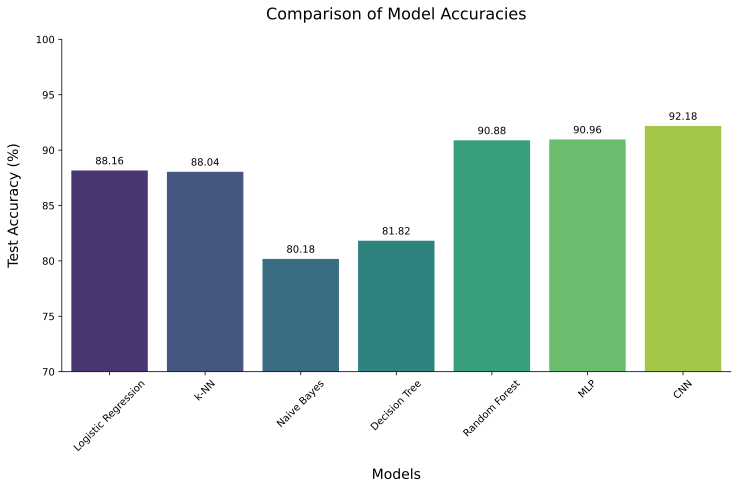

In [52]:
import seaborn as sns

import pandas as pd
accuracies = {
    'Logistic Regression': 88.16,  
    'k-NN': 88.04,  
    'Naive Bayes': 80.18,  
    'Decision Tree': 81.82,  
    'Random Forest': 90.88,  
    'MLP': 90.96,  
    'CNN': 92.18  
}

accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Test Accuracy'])

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Model', y='Test Accuracy', data=accuracy_df, palette='viridis')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.ylim(70, 100) 
plt.xlabel('Models', labelpad=15, fontsize=14)
plt.ylabel('Test Accuracy (%)', labelpad=15, fontsize=14)
plt.title('Comparison of Model Accuracies', pad=20, fontsize=16)
plt.xticks(rotation=45)
sns.despine() 
plt.show()
